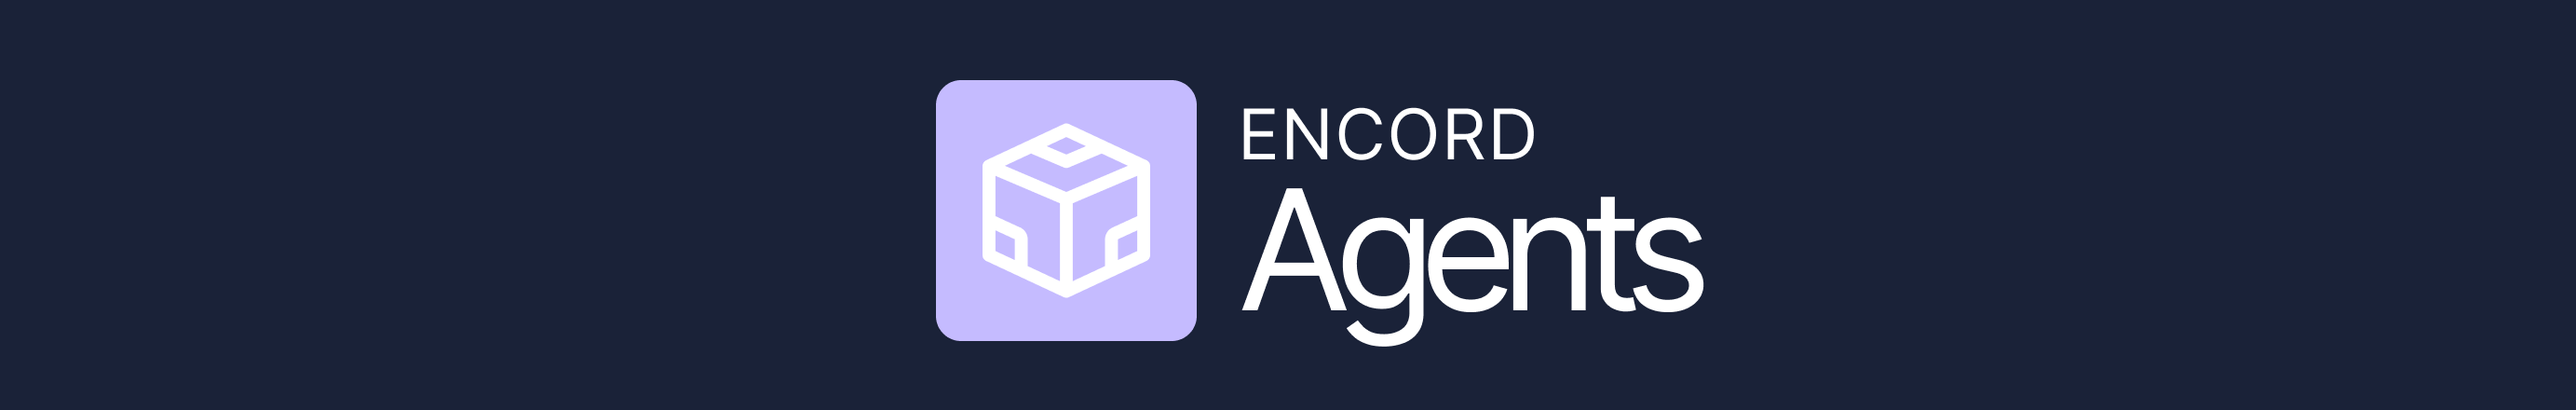


# Use the Ultralytics YOLO Model

This notebook demonstrates how to use a task agent to pre-label images with predictions, specifically using a bounding box prediction model.

Before we begin, ensure that all dependencies are installed and that you are authenticated with Encord.


## Set Up

### Installation

Ensure that you have the `encord-agents` library installed:

In [ ]:
!python -m pip install encord-agents

### Encord Authentication

Encord uses ssh-keys for authentication. The following is a code cell for setting the `ENCORD_SSH_KEY` environment variable. It contains the raw content of your private ssh key file.

If you have not setup an ssh key, see our [documentation](https://agents-docs.encord.com/authentication/).

> 💡 In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks. IF YOU ARE NOT RUNNING THE CODE IN THE COLLAB NOTEBOOK, you must set the environment variable directly.
> ```python
> os.environ["ENCORD_SSH_KEY"] = """paste-private-key-here"""
> ```

In [ ]:
from google.colab import userdata

key_contet = userdata.get("ENCORD_SSH_KEY")

In [ ]:
import os

os.environ["ENCORD_SSH_KEY"] = key_contet
# or you can set a path to a file
# os.environ["ENCORD_SSH_KEY_FILE"] = "/path/to/your/private/key"

#### [Alternative] Temporary Key
There's also the option of generating a temporary (fresh) ssh key pair via the code cell below.
Please follow the instructions printed when executing the code.

In [ ]:
# ⚠️ Safe to skip if you have authenticated already
import os

from encord_agents.utils.colab import generate_public_private_key_pair_with_instructions

private_key_path, public_key_path = generate_public_private_key_pair_with_instructions()
os.environ["ENCORD_SSH_KEY_FILE"] = private_key_path.as_posix()

## Set up your Ontology

Create an Ontology that matches the expected output of your pre-labeling agent.
For example, if your model predicts classes `surfboard`, `person`, and `car`, then the Ontology should look like this:

> 💡 Our DETR model predicts more objects but here the focus on the car predictions in this example

<figure style="text-align: center">
  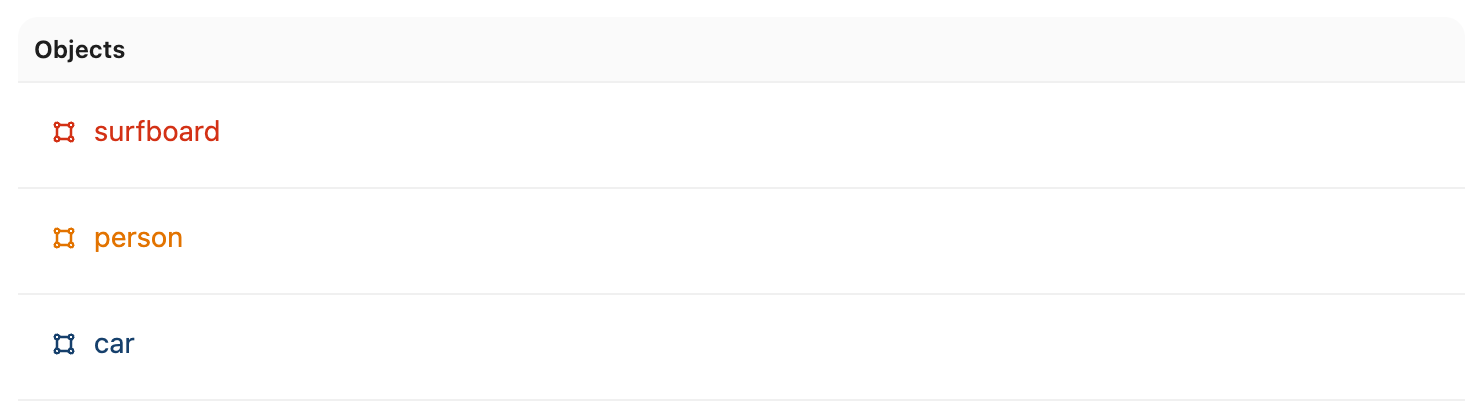
  <figcaption><stong>Figure 1:</strong> Project Ontology.</figcaption>
</figure>

### Define an Ontology Map

We need to map the model predictions to their respective Encord Ontology items. The simplest way to do this is by using the `featureNodeHash` of the target, which can be found either through the Ontology preview JSON in the app or by using the Encord SDK.


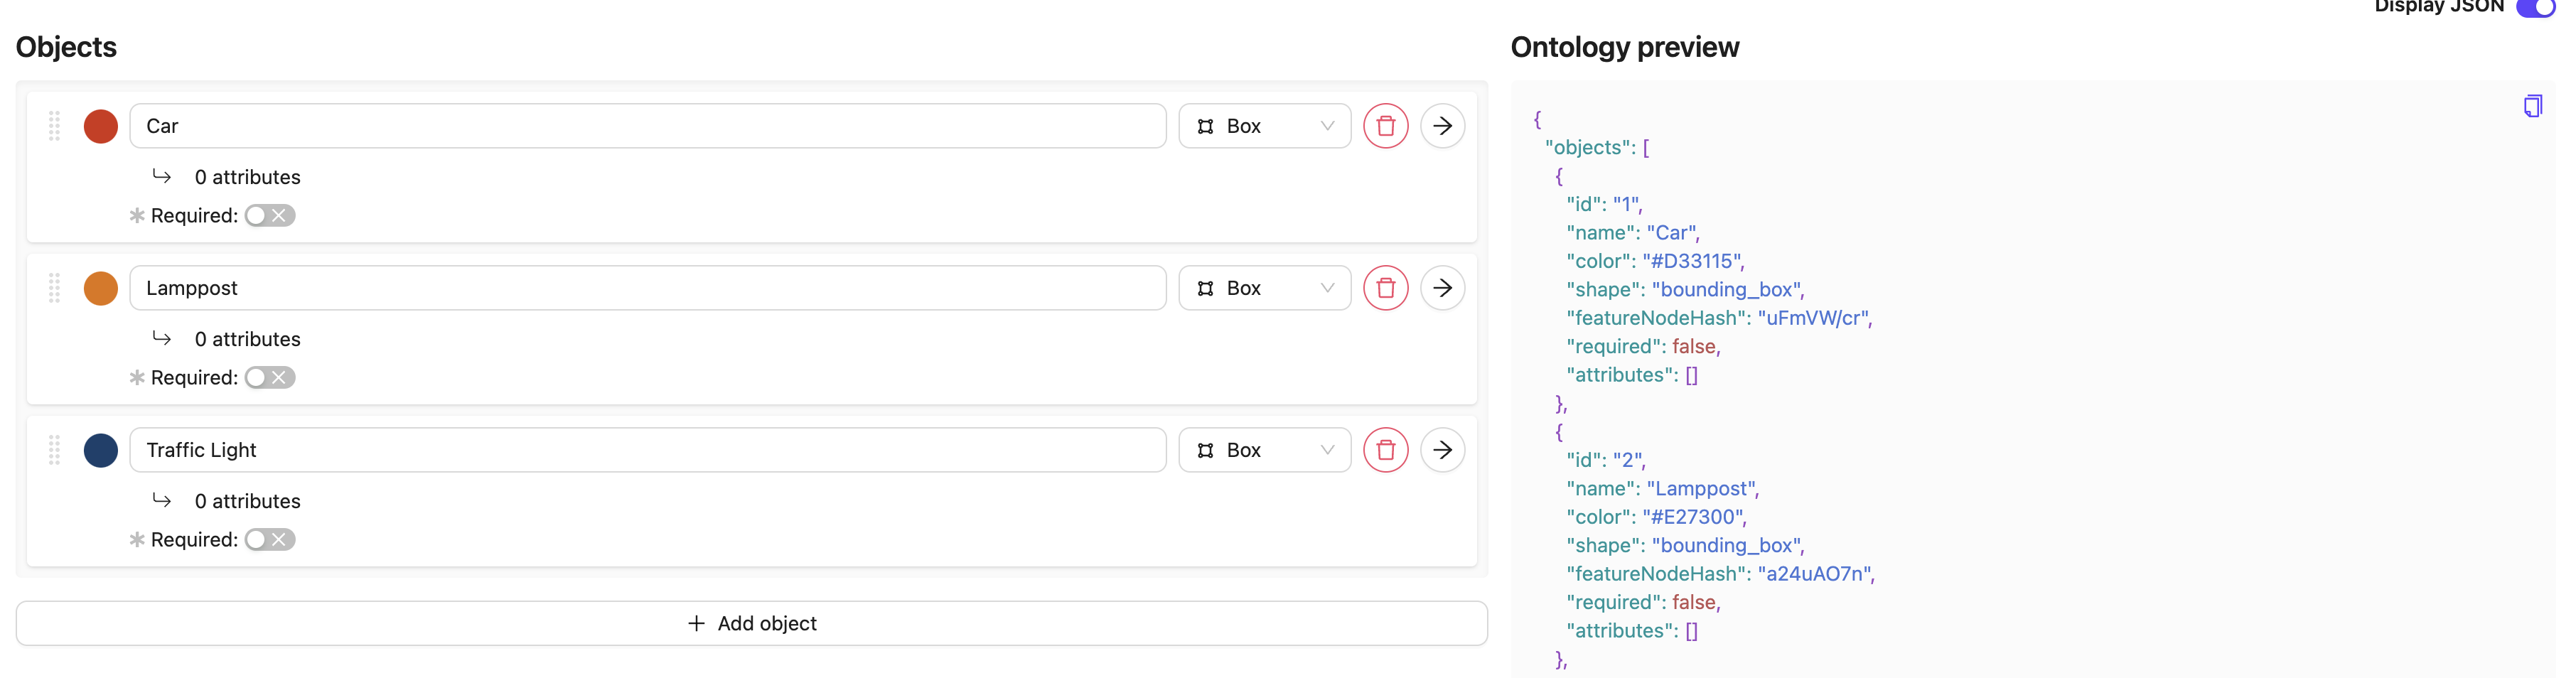

In [ ]:
ontology_map = {"car": "uFmVW/cr"}

## Define a Model for Predictions

Define a model that predicts labels, bounding boxes, and confidence scores, and use it to detect objects in images.

We'll use the YOLOv11 model from Ultralytics following:
https://docs.ultralytics.com/modes/predict/

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

[📖 See our documentation here](https://docs.encord.com/platform-documentation/GettingStarted/gettingstarted-create-ontology) to learn how to create Ontologies.

In [ ]:
from dataclasses import dataclass

import numpy as np
from encord.objects.coordinates import BoundingBoxCoordinates
from numpy.typing import NDArray


# Data class to hold predictions from our model
@dataclass
class ModelPrediction:
    featureHash: str
    coords: BoundingBoxCoordinates
    conf: float


def YOLO_predict(image: NDArray[np.uint8]) -> list[ModelPrediction]:
    print(image, image.shape, type(image))
    outputs = model(image)

    print(outputs)
    for output in outputs:
        clses = [ontology_map[x] for x in output.boxes.cls.tolist()]
        print(clses)
        confs = output.boxes.conf.tolist()
        boxes = output.boxes.xywhn.tolist()
        encord_boxes = [
            BoundingBoxCoordinates(height=x[3], width=x[2], top_left_x=x[0], top_left_y=x[1]) for x in boxes
        ]
        return [ModelPrediction(featureHash=x, coords=y, conf=z) for x, y, z in zip(clses, encord_boxes, confs)]


agent = YOLO_predict

## Create a Workflow

Create a Project in the Encord platform with the following Workflow.

The Workflow includes a pre-labeling agent node before the annotation stage. This agent node automatically pre-labels tasks with model predictions, where your custom code for pre-labeling is executed.

<figure style="text-align: center">
  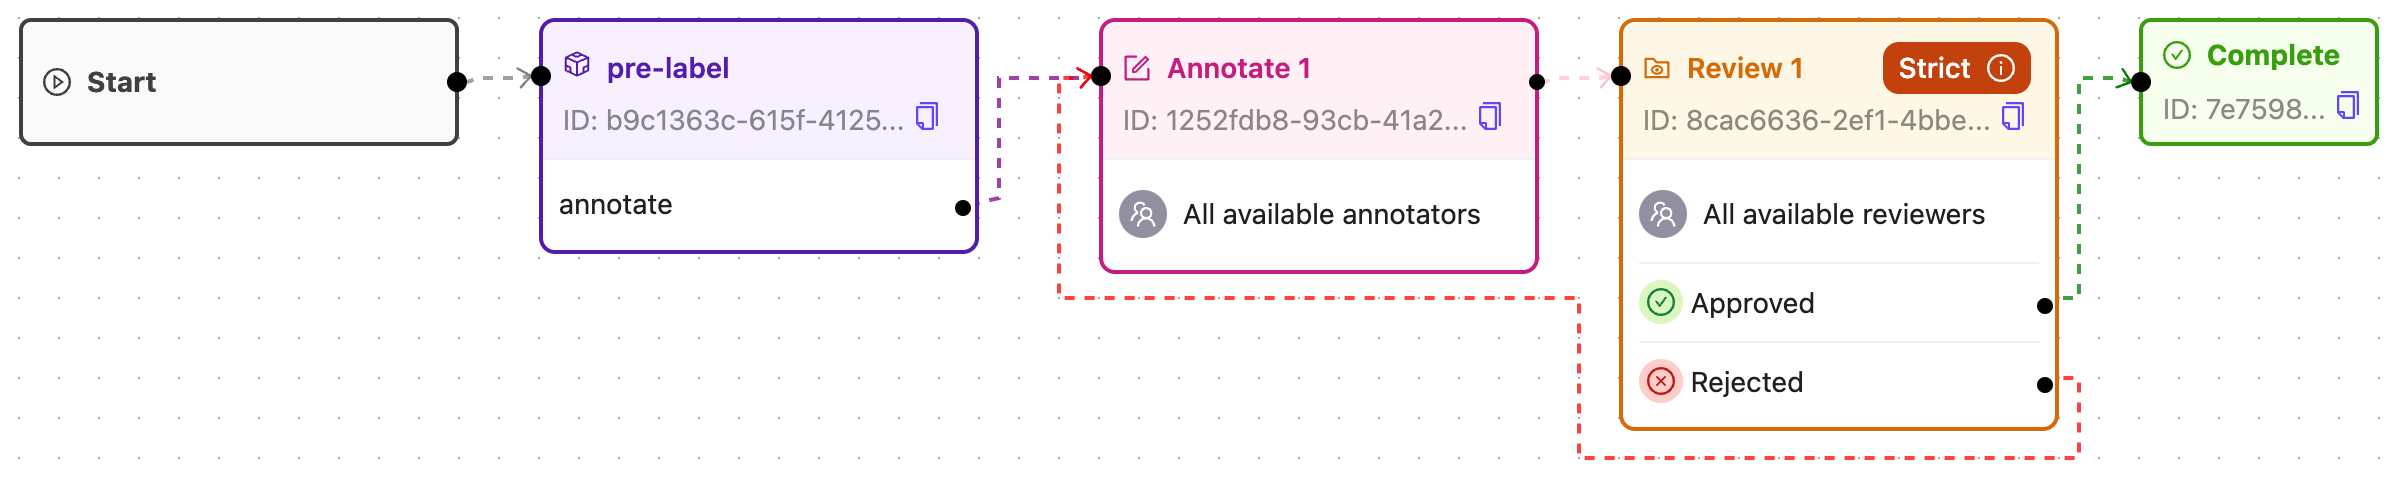
  <figcaption><strong>Figure 2:</strong> Project workflow.</figcaption>
</figure>

[📖 See our documentation here](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-workflows-and-templates#creating-workflows) to learn how to create a Workflow in Encord.

## Define the Pre-Labeling Agent

The following code provides a template for defining an agent that does pre-labeling. The code uses the [`dep_video_iterator` dependency](../../reference/task_agents.md#encord_agents.tasks.dependencies.dep_video_iterator) to automatically load an iterator of frames as RGB numpy arrays from the video.

Ensure that you replace `<project-hash>` with the unique ID of your Encord Project.

> ⚠️ This example assumes:
> - Your Project contains only videos, and you want to pre-label all frames in each video.
> - The agent stage is named "pre-label" and the pathway is named "annotate." If your setup differs, update the `stage` parameter of the decorator and the returned string accordingly.


In [ ]:
from typing import Iterable

import numpy as np
from encord.objects.ontology_labels_impl import LabelRowV2
from encord.project import Project
from numpy.typing import NDArray
from typing_extensions import Annotated

from encord_agents.core.data_model import Frame
from encord_agents.tasks import Depends, Runner
from encord_agents.tasks.dependencies import dep_single_frame

# a. Define a runner that executes the agent on every task in the agent stage
runner = Runner(project_hash="<project-hash>")


# b. Specify the logic that goes into the "pre-label" agent node.
@runner.stage(stage="pre-label")
def pre_segment(
    lr: LabelRowV2,
    project: Project,
    frame: Annotated[NDArray[np.uint8], Depends(dep_single_frame)],
) -> str:
    ontology = project.ontology_structure

    # d. Predict  -  we could do batching here to speed up the process
    outputs = agent(frame)

    # e. Store the results
    for output in outputs:
        ins = ontology.get_child_by_hash(output.featureHash).create_instance()
        ins.set_for_frames(frames=0, coordinates=output.coords, confidence=output.conf)

        lr.add_object_instance(ins)

    lr.save()
    return "annotate"  # Tell where the task should go

## Running the Agent
The `runner` object is callable which means that you can just call it to prioritize your tasks.

In [ ]:
# Run the agent
runner()

## Outcome

Your agent now assigns labels to the videos and routes them appropriately through the Workflow to the annotation stage.
As a result, every annotation task should already have pre-existing labels (predictions) included.

> 💡 To run this as a command-line interface, save the code in an `agents.py` file and replace:  
> ```python
> runner()
> ```  
> with:  
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```  
> This lets you set parameters like the project hash from the command line:  
> ```bash
> python agent.py --project-hash "..."
> ```



